In [1]:
import catboost
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import scipy.stats as stats
import sweetviz

from sklearn.model_selection import train_test_split
from nflows.distributions import ConditionalDiagonalNormal

from src.probabilistic_flow_boosting.tfboost.tree import EmbeddableCatBoostPriorNormal
from src.probabilistic_flow_boosting.tfboost.tfboost import TreeFlowBoost
from src.probabilistic_flow_boosting.tfboost.flow import ContinuousNormalizingFlow
from src.probabilistic_flow_boosting.pipelines.reporting.nodes import calculate_nll

from src.probabilistic_flow_boosting.pipelines.modeling.utils import setup_random_seed

RANDOM_SEED = 5

setup_random_seed(RANDOM_SEED)

In [2]:
df = pd.read_csv('data/01_raw/CatData/pak-wheels/PakWheelsDataSet.csv', index_col=0)

In [3]:
# analysis = sweetviz.analyze(df)
# analysis.show_notebook()

In [4]:
x = df.drop(columns = ['Name', 'Price'])
y = np.log10(df[['Price']])

In [5]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state=42)
x_tr, x_val, y_tr, y_val = train_test_split(x_train, y_train, test_size = 0.2, random_state=42)

In [6]:
x_train.shape, x_test.shape

((61352, 7), (15338, 7))

In [7]:
x.columns

Index(['Make', 'Transmission', 'Engine Type', 'Engine Capacity(CC)',
       'Mileage(kms)', 'City', 'Year'],
      dtype='object')

In [8]:
model = catboost.CatBoostRegressor(
    cat_features=['Make', 'Transmission', 'Engine Type', 'City'], 
    loss_function="RMSEWithUncertainty",
    num_trees=2000,
    random_state=RANDOM_SEED
)

In [9]:
%time model.fit(x_tr, y_tr, eval_set=(x_val, y_val))

0:	learn: 0.2642201	test: 0.2554129	best: 0.2554129 (0)	total: 102ms	remaining: 3m 23s
1:	learn: 0.2190374	test: 0.2122238	best: 0.2122238 (1)	total: 113ms	remaining: 1m 53s
2:	learn: 0.1836126	test: 0.1777690	best: 0.1777690 (2)	total: 121ms	remaining: 1m 20s
3:	learn: 0.1539971	test: 0.1486995	best: 0.1486995 (3)	total: 131ms	remaining: 1m 5s
4:	learn: 0.1266005	test: 0.1215709	best: 0.1215709 (4)	total: 140ms	remaining: 55.7s
5:	learn: 0.1025298	test: 0.0978055	best: 0.0978055 (5)	total: 150ms	remaining: 49.8s
6:	learn: 0.0789534	test: 0.0743807	best: 0.0743807 (6)	total: 158ms	remaining: 45.1s
7:	learn: 0.0555157	test: 0.0512054	best: 0.0512054 (7)	total: 167ms	remaining: 41.6s
8:	learn: 0.0325224	test: 0.0283644	best: 0.0283644 (8)	total: 175ms	remaining: 38.7s
9:	learn: 0.0105054	test: 0.0063839	best: 0.0063839 (9)	total: 185ms	remaining: 36.7s
10:	learn: -0.0101789	test: -0.0142646	best: -0.0142646 (10)	total: 193ms	remaining: 34.9s
11:	learn: -0.0310053	test: -0.0350014	best: -

In [10]:
def calculate_nll_catboost(model: catboost.CatBoostRegressor, x: pd.DataFrame, y: pd.DataFrame):
    x: np.ndarray = x.values
    y: np.ndarray = y.values

    if y.shape[1] > 1:
        return np.nan

    y_hat_tree = model.predict(x)
    y_hat_tree[:, 1] = np.log(np.sqrt(y_hat_tree[:, 1]))  # Transform var to log std / CatBoost RMSEWithUncertainty

    distribution = ConditionalDiagonalNormal(shape=[1])  # Assume 1D distribution
    return -distribution.log_prob(y, y_hat_tree).numpy().mean()

In [11]:
%time calculate_nll_catboost(model, x_train, y_train)

CPU times: user 1 s, sys: 42.7 ms, total: 1.05 s
Wall time: 124 ms


-1.507447104624352

In [12]:
%time calculate_nll_catboost(model, x_test, y_test)

CPU times: user 861 ms, sys: 25.2 ms, total: 886 ms
Wall time: 44.2 ms


-1.430278918716062

In [13]:
tree = EmbeddableCatBoostPriorNormal(
    cat_features=[0, 1, 2, 5], 
    loss_function="RMSEWithUncertainty",
    depth=5,
    num_trees=100,
    random_state=RANDOM_SEED
)
flow = ContinuousNormalizingFlow(input_dim=1, hidden_dims=(100, 100, 50), context_dim=100, conditional=True)

treeflow = TreeFlowBoost(tree, flow, embedding_size=100)

In [14]:
%time treeflow.fit(x_tr.values, y_tr.values, x_val.values, y_val.values, n_epochs=50, batch_size=2048, verbose=True)

0:	learn: 0.2658222	total: 6.34ms	remaining: 628ms
1:	learn: 0.2250335	total: 12.6ms	remaining: 620ms
2:	learn: 0.1911748	total: 17.2ms	remaining: 556ms
3:	learn: 0.1622996	total: 21.8ms	remaining: 523ms
4:	learn: 0.1339875	total: 27.8ms	remaining: 529ms
5:	learn: 0.1093128	total: 32.3ms	remaining: 507ms
6:	learn: 0.0850230	total: 36.9ms	remaining: 491ms
7:	learn: 0.0632488	total: 41.5ms	remaining: 477ms
8:	learn: 0.0418171	total: 49.2ms	remaining: 497ms
9:	learn: 0.0211658	total: 53.8ms	remaining: 484ms
10:	learn: 0.0014394	total: 58.4ms	remaining: 473ms
11:	learn: -0.0181939	total: 63.1ms	remaining: 463ms
12:	learn: -0.0378622	total: 67.7ms	remaining: 453ms
13:	learn: -0.0568395	total: 72.2ms	remaining: 443ms
14:	learn: -0.0767445	total: 76.8ms	remaining: 435ms
15:	learn: -0.0961029	total: 81.3ms	remaining: 427ms
16:	learn: -0.1141008	total: 86ms	remaining: 420ms
17:	learn: -0.1321287	total: 90.5ms	remaining: 412ms
18:	learn: -0.1506572	total: 95.1ms	remaining: 405ms
19:	learn: -0.16

TreeFlowBoost(embedding_size=100,
              flow_model=<src.probabilistic_flow_boosting.tfboost.flow.flow.ContinuousNormalizingFlow object at 0x7f1192692518>,
              tree_model=<src.probabilistic_flow_boosting.tfboost.tree.ecatboost.EmbeddableCatBoostPriorNormal object at 0x7f1192692668>)

In [15]:
%time calculate_nll(treeflow, x_train, y_train, batch_size = 1024)

CPU times: user 57.2 s, sys: 1.89 s, total: 59 s
Wall time: 48.6 s


-1.6381193

In [16]:
%time calculate_nll(treeflow, x_test, y_test, batch_size = 1024)

CPU times: user 18.4 s, sys: 635 ms, total: 19 s
Wall time: 12.7 s


-1.5532237

In [17]:
data = x_test.iloc[:10, :]

In [18]:
y_test_catboost = model.predict(data)

y_test_samples = treeflow.sample(data, num_samples=1000)
y_test_samples = y_test_samples.squeeze()

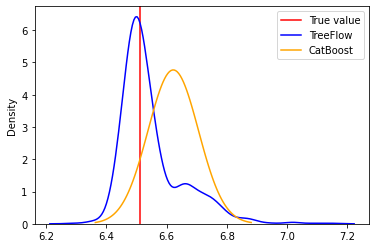

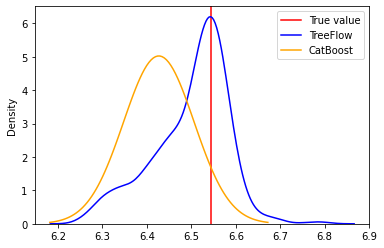

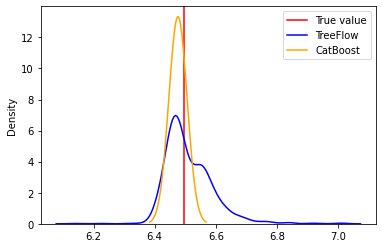

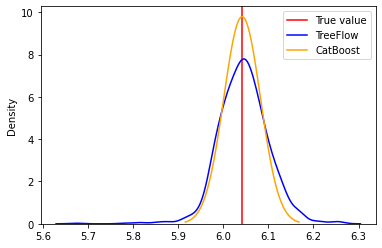

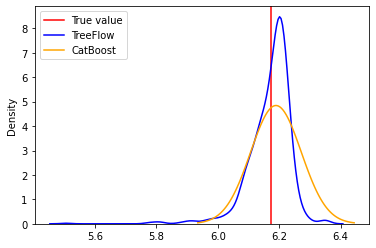

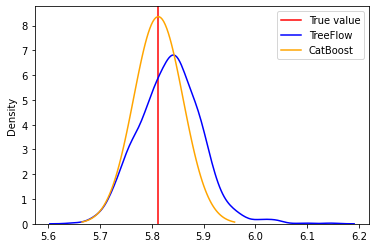

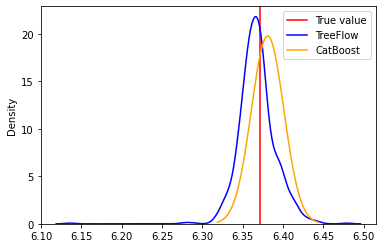

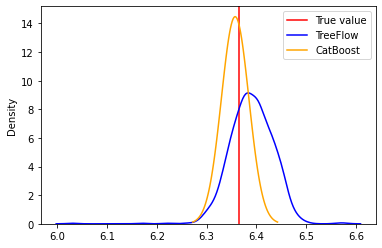

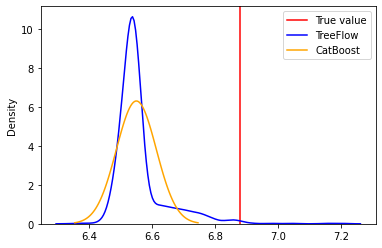

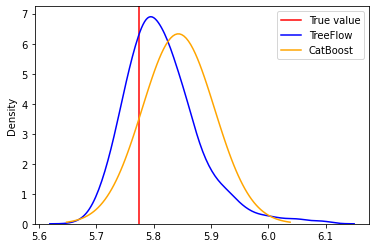

In [19]:
for i in range(10):
    plt.axvline(x=y_test.values[i, :], color='r', label='True value')

    sns.kdeplot(y_test_samples[i, :], color='blue', label='TreeFlow')

    x = np.linspace(
        stats.norm.ppf(0.001, loc=y_test_catboost[i, 0], scale=np.sqrt(y_test_catboost[i, 1])), 
        stats.norm.ppf(0.999, loc=y_test_catboost[i, 0], scale=np.sqrt(y_test_catboost[i, 1])), 
        100
    )
    plt.plot(x, stats.norm.pdf(x, loc=y_test_catboost[i, 0], scale=np.sqrt(y_test_catboost[i, 1])), color = 'orange', label='CatBoost')

    plt.legend()
    plt.show()